In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
import optuna

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import sys
sys.path.append('../src')
from EvaluationFunction import evaluate_model
from OptunaXGB import objective
from PreprocessingFunction import build_preprocessor

from collections import Counter

import joblib

RANDOM_STATE = 42

In [93]:
# Load preprocessed data
df_cleaned = pd.read_csv("../data/preprocessed_data.csv")

In [94]:
# Split features and target variable
X = df_cleaned.drop('Exited', axis=1)
y = df_cleaned['Exited']

---
Preprocessing
---

In [95]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)

In [96]:
preprocessor = build_preprocessor(X_train)
ratio = Counter(y_train)[0] / Counter(y_train)[1]

---
Optuna
---

[I 2025-12-31 20:11:02,078] A new study created in memory with name: no-name-6bedb7d0-27fa-407b-87d4-27756989a64d
[I 2025-12-31 20:11:06,434] Trial 0 finished with value: 0.9360913658571965 and parameters: {'n_estimators': 197, 'max_depth': 3, 'learning_rate': 0.033916109429434925, 'subsample': 0.8393892154302262}. Best is trial 0 with value: 0.9360913658571965.
[I 2025-12-31 20:11:13,242] Trial 1 finished with value: 0.9267225084418689 and parameters: {'n_estimators': 579, 'max_depth': 7, 'learning_rate': 0.03933305753139763, 'subsample': 0.8760492128586737}. Best is trial 0 with value: 0.9360913658571965.
[I 2025-12-31 20:11:19,710] Trial 2 finished with value: 0.9235974809427493 and parameters: {'n_estimators': 617, 'max_depth': 9, 'learning_rate': 0.04777713496316412, 'subsample': 0.9784536873278017}. Best is trial 0 with value: 0.9360913658571965.
[I 2025-12-31 20:11:25,298] Trial 3 finished with value: 0.9318500358474457 and parameters: {'n_estimators': 408, 'max_depth': 7, 'lear


--- ÉVALUATION OPTUNA ---
Accuracy: 0.8953333333333333
Precision: 0.8047210300429185
Recall: 0.6270903010033445
F1-score: 0.7048872180451128
AUC: 0.9339795571694713

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.80      0.63      0.70       598

    accuracy                           0.90      3000
   macro avg       0.86      0.79      0.82      3000
weighted avg       0.89      0.90      0.89      3000



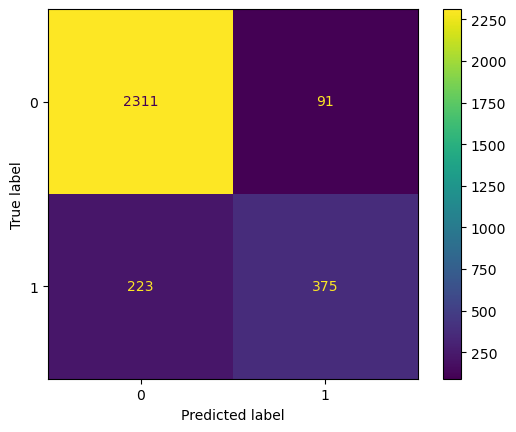

In [97]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "scale_pos_weight": ratio,
        "eval_metric": "logloss",
        "random_state": 42
    }
    model = XGBClassifier(**params)
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_opt_xgb = XGBClassifier(**study.best_params, random_state=42)
optuna_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_opt_xgb)])
optuna_pipe.fit(X_train, y_train)

print("\n--- ÉVALUATION OPTUNA ---")
evaluate_model(y_test, optuna_pipe.predict(X_test), optuna_pipe.predict_proba(X_test)[:, 1])


---
GridSearchCV
---


--- ÉVALUATION GRIDSEARCH ---
Accuracy: 0.894
Precision: 0.7857142857142857
Recall: 0.6438127090301003
F1-score: 0.7077205882352942
AUC: 0.9332022645565707

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2402
           1       0.79      0.64      0.71       598

    accuracy                           0.89      3000
   macro avg       0.85      0.80      0.82      3000
weighted avg       0.89      0.89      0.89      3000



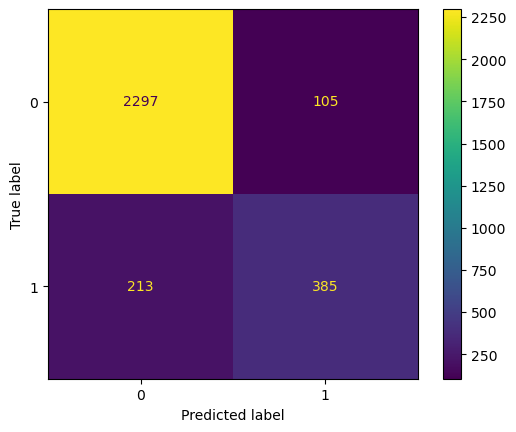

In [98]:
param_grid = {
    "classifier__n_estimators": [study.best_params["n_estimators"] - 50, study.best_params["n_estimators"] + 50],
    "classifier__max_depth": [study.best_params["max_depth"] - 1, study.best_params["max_depth"] + 1]
}

grid = GridSearchCV(optuna_pipe, param_grid, scoring="roc_auc", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n--- ÉVALUATION GRIDSEARCH ---")
evaluate_model(y_test, grid.predict(X_test), grid.predict_proba(X_test)[:, 1])

In [99]:
print(auc_opt)

0.9328559116009791


In [100]:
print(auc_gs)

0.934072150019911


---
Class Churn Imbalance 
---


>>> ANALYSE : Sans Équilibre
Accuracy: 0.8953333333333333
Precision: 0.8047210300429185
Recall: 0.6270903010033445
F1-score: 0.7048872180451128
AUC: 0.9339795571694713

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.80      0.63      0.70       598

    accuracy                           0.90      3000
   macro avg       0.86      0.79      0.82      3000
weighted avg       0.89      0.90      0.89      3000



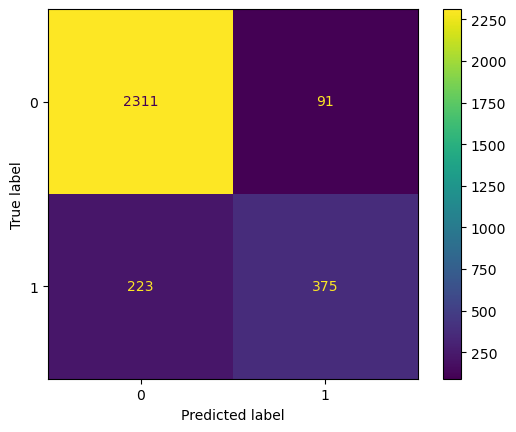


>>> ANALYSE : Weight Only
Accuracy: 0.8643333333333333
Precision: 0.6140979689366786
Recall: 0.8595317725752508
F1-score: 0.716376306620209
AUC: 0.9340345559302587

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2402
           1       0.61      0.86      0.72       598

    accuracy                           0.86      3000
   macro avg       0.79      0.86      0.81      3000
weighted avg       0.89      0.86      0.87      3000



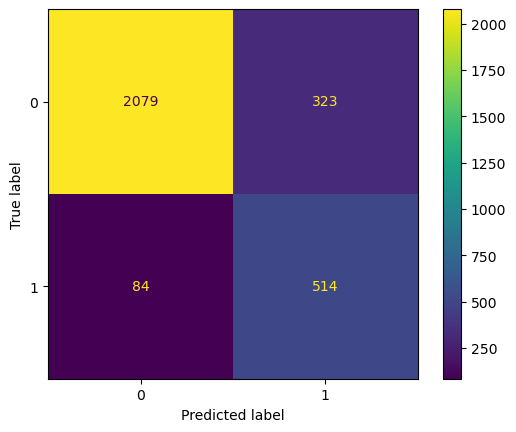


>>> ANALYSE : SMOTE Only
Accuracy: 0.8736666666666667
Precision: 0.6469798657718121
Recall: 0.8060200668896321
F1-score: 0.7177959791511541
AUC: 0.9309187717036249

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      2402
           1       0.65      0.81      0.72       598

    accuracy                           0.87      3000
   macro avg       0.80      0.85      0.82      3000
weighted avg       0.89      0.87      0.88      3000



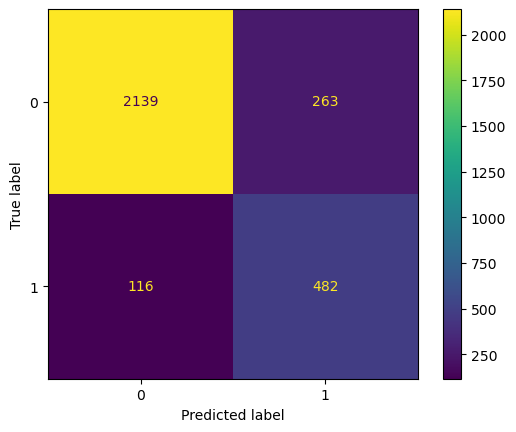


>>> ANALYSE : SMOTE + Weight
Accuracy: 0.7853333333333333
Precision: 0.4799651567944251
Recall: 0.9214046822742475
F1-score: 0.6311569301260023
AUC: 0.930406378185403

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      2402
           1       0.48      0.92      0.63       598

    accuracy                           0.79      3000
   macro avg       0.73      0.84      0.74      3000
weighted avg       0.88      0.79      0.81      3000



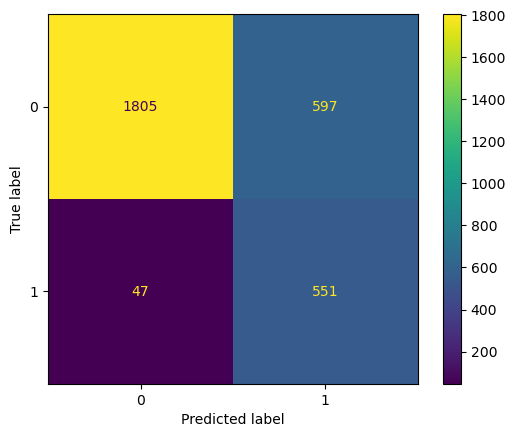

In [101]:
auc_opt = roc_auc_score(y_test, optuna_pipe.predict_proba(X_test)[:, 1])
auc_gs = roc_auc_score(y_test, grid.predict_proba(X_test)[:, 1])

best_params_moteur = grid.best_estimator_.named_steps['classifier'].get_params() if auc_gs >= auc_opt else best_opt_xgb.get_params()
best_params_moteur = {k: v for k, v in best_params_moteur.items() if k not in ['scale_pos_weight']}

strategies = {
    "Sans Équilibre": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "Weight Only": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))]),
    "SMOTE Only": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "SMOTE + Weight": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))])
}

final_auc = {}
for name, pipe in strategies.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    final_auc[name] = roc_auc_score(y_test, y_prob)
    print(f"\n>>> ANALYSE : {name}")
    evaluate_model(y_test, y_pred, y_prob)

---
Selection the best model
---

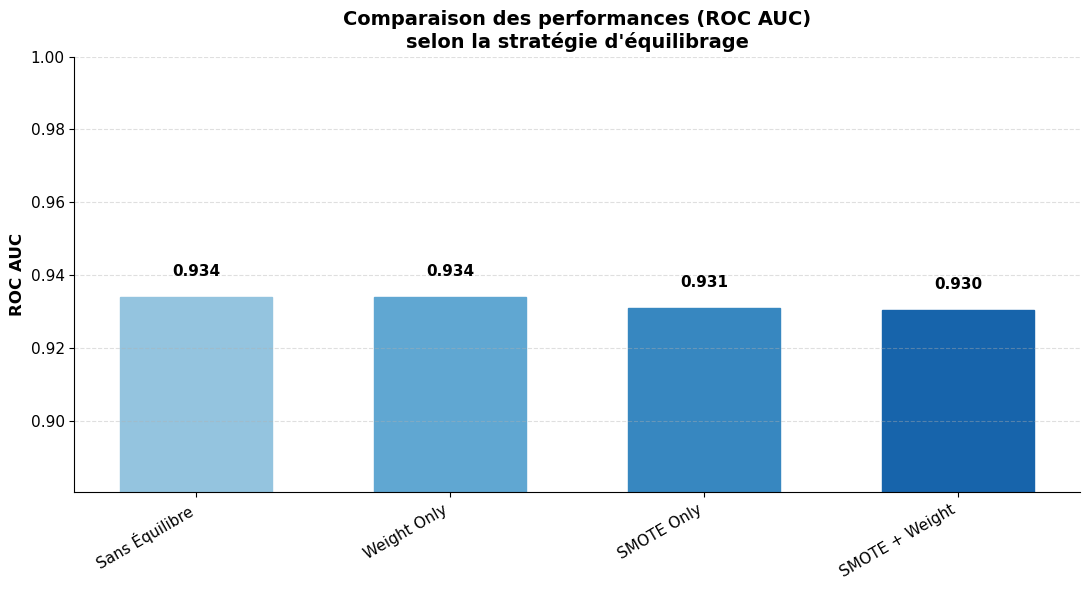

In [102]:
# --- DATA ---
labels = list(final_auc.keys())
values = list(final_auc.values())

# --- FIGURE ---
plt.figure(figsize=(11, 6))

bars = plt.bar(
    labels,
    values,
    width=0.6,
    edgecolor='black',
    linewidth=1
)

# --- COULEURS (gradient propre) ---
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# --- ANNOTATIONS (AUC sur les barres) ---
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# --- AXES & TITRES ---
plt.ylim(min(values) - 0.05, 1.0)
plt.ylabel("ROC AUC", fontsize=12, fontweight='bold')
plt.title(
    "Comparaison des performances (ROC AUC)\nselon la stratégie d'équilibrage",
    fontsize=14,
    fontweight='bold'
)

# --- STYLE PRO ---
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Suppression des bordures inutiles
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [103]:
best_key = max(final_auc, key=final_auc.get)
joblib.dump(strategies[best_key], '../models/best_model.pkl')

['../models/best_model.pkl']